## Astro 100: Homework 2 
by Alexander McPike

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
import os
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
from astropy.convolution import convolve, Box1DKernel, Box2DKernel

In [3]:
from photutils import DAOStarFinder
from astropy.stats import mad_std

In [4]:
from astropy import wcs
from astropy.wcs import WCS
from astropy.table import Table

In [5]:
from photutils import aperture_photometry, CircularAperture

In [6]:
from astropy.table import QTable
from astropy import units as u
from astropy import constants as const
from astropy.units import imperial

In [7]:
from astropy.coordinates import SkyCoord

## Step 1

This week we continue assembling pieces of an image reduction
pipeline, and compare to other measurements.

Take the image we have been using

PTF_201307021787_i_p_scie_t041723_u016616794_f02_p003486_c11.fits

and examine the header, looking for the World Coordinate System
information.  This is in human-readable form in the header of the
file, so you can even type
more PTF_201307021787_i_p_scie_t041723_u016616794_f02_p003486_c11.fits

and scroll down until you see this

WCSAXES =                    2 / Number of axes in world coordinate system      
CRVAL1  =     217.309490953823 / [deg] RA of reference point                    
CRVAL2  =     16.6581466832508 / [deg] DEC of reference point                   
CRPIX1  =             1497.193 / [pix] Image reference point                    
CRPIX2  =             609.3031 / [pix] Image reference point                    
 
 . . .

This tells you that (x,y)= (1497.193, 609.3031) is the reference point
in the image (the tangent point on the celestial sphere) and that that
point corresponds to (RA, dec) = (217.309, 16.658).

The pixel scale is about 0.000280 deg/pixel. 


In [8]:
dir_ = "../../Notes/2020_02_04_Astropy_and_Fits/data/"
imageName = 'PTF_201307021787_i_p_scie_t041723_u016616794_f02_p003486_c11.fits'
print(dir_+imageName)
f  = fits.open(dir_+imageName)
exampleData = f[0].data #This is the image array, "pulling out the image array"

../../Notes/2020_02_04_Astropy_and_Fits/data/PTF_201307021787_i_p_scie_t041723_u016616794_f02_p003486_c11.fits


In [9]:
exampleHeader = f[0].header
exampleHeader  

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / FOUR-BYTE SINGLE PRECISION FLOATING POINT      
NAXIS   =                    2 / STANDARD FITS FORMAT                           
NAXIS1  =                 2048 / STANDARD FITS FORMAT                           
NAXIS2  =                 4096 / STANDARD FITS FORMAT                           
ORIGIN  = 'Palomar Transient Factory' / Origin of these image data              
CREATOR = 'Infrared Processing and Analysis Center' / Creator of this FITS file 
TELESCOP= 'P48     '           / Name of telescope                              
INSTRUME= 'PTF/MOSAIC'         / Instrument name                                
OBSERVER= 'KulkarniPTF'        / Observer name and project                      
CCDID   = '11      '           / CCD number (0..11)                             
DATE-OBS= '2013-07-02T04:17:23.555' / UTC shutter time YYYY-MM-DDTHH:MM:SS.SSS  
DATE    = '2013-07-01T21:35:

## Step 2

Read about the astropy WCS package

https://docs.astropy.org/en/stable/wcs/

focusing for now on wcs_pix2world()


#### 1.  What is the difference between wcs_pix2world() and all_pix2world() ?
    
       The image transformation that takes place. wcs_pix2world() only applies the wcslib transformation, while all_pix2world() applies a series of transformations.
       
       

#### 2.  What is a SIP convention for representing distortions (in one sentence)?

        It's a way of storing information about the distortion of the image in the header of FITS images. 

## Step 3

Now let's have a look at the Gaia archive.  If you are unfamiliar with
Gaia, please read
https://sci.esa.int/web/gaia/-/28820-summary

If you already know about Gaia, you can jump straight here
https://gea.esac.esa.int/archive/
and click on "Search"

Please query objects within a radius of 15 arcminutes of 

RA = 217.309, dec = 16.658   (J2000 ICRS coordinates)

and download this file as a FITS file.
If you are unsure how to read a FITS binary table, this may help
https://docs.astropy.org/en/stable/io/fits/

## Step 4

Next convert those (RA, dec) coordinates to (x,y) pixel coordinates in
our image.

Overplot them as circles of an appropriate size, maybe
with transparency 0.5, on the image.  Does the astrometry look right?

FITS headers have a 1-indexed convention, and Python is 0-indexed.  Is
that OK?


In class, we write a "findstar" function to find stars in an image,
and then we also used DAOFind.

Please run those on the image, and make a scatterplot with symbols for
findstar, DAOFind, and the Gaia (x,y) positions.  We want to be able
to see any offsets, so maybe zoom in on some interesting region of the
X and Y range rather than plotting the entire thing.  Do the 3 ways of
finding star positions seem to line up?


Please take a stab at this before Tuesday, and then we'll be happy to
stay after class and talk through pieces of this with you.


In [10]:
#importing the Gaia data
fitsFile = fits.open('../../Students/AlexanderMcPike/mcpikeGaiaData.fits')
# fileName = get_pkg_data_filename('../../Students/AlexanderMcPike/mcpikeGaiaData.fits')
#hdu = fitsFile[1]

#printing a table to make sure it imported correctly
# gaiaData = fits.getdata(fileName, ext=1)
# table = Table(gaiaData)
# table

In [11]:
coord = SkyCoord(ra = 217.309, dec=16.658, unit=(u.degree, u.degree), frame='icrs')
table = Gaia.query_object_async(coordinate=coord, radius = 15* u.arcmin)

#header = table[0].header
w = wcs.WCS(exampleHeader)



#creating the arrays to be converted
# source_id = np.copy(gaiaData["source_id"])
# ra = np.copy(gaiaData.field(1))
# dec = np.copy(gaiaData.field(3))
#worldcoord = np.array([ra, dec]).T

worldcoord = np.array([table['ra'], table['dec']]).T

pixelcoord = w.wcs_world2pix(worldcoord, 1)

pixelcoord


#plt.scatter(pixelcoord[0],pixelcoord[1])

# px, py = w.wcs_pix2world(ra, dec, 1)

INFO: Query finished. [astroquery.utils.tap.core]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


array([[1484.98433027,  584.31404285],
       [1468.42515455,  587.60205066],
       [1478.83219079,  563.8360864 ],
       ...,
       [1235.00668515, -240.93654819],
       [ 678.66128546,  253.34763746],
       [1627.41797316, -270.06566022]])

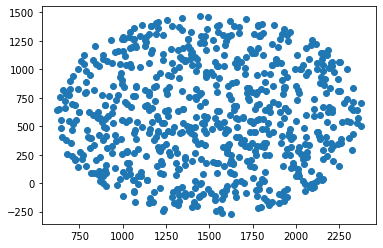

In [12]:
plt.scatter(pixelcoord[:,0],pixelcoord[:,1])

In [19]:
def findstars(image,nstar=10):
    
    #get the x's and y's from this function and call the aperture photometry function

    #sy,sx = image.shape
    npad=5
    #nstar=10
    blankval = -1
    
    #Initialize output arrays
    x = np.zeros(nstar).astype('int32') #you can't use floating point numbers to index into an array
    y = np.zeros(nstar).astype('int32')
    flux=np.zeros(nstar)
    
    #Trim edges of the image
    image[0:npad,:] = blankval 
    image[:,0:npad] = blankval 
    image[-npad-1:-1,:] = blankval
    image[:,-npad-1:-1] = blankval
    
    #Loop over stars
    for i in np.arange(nstar):
        indmax = np.argmax(image)
        y[i],x[i] = np.unravel_index(indmax,image.shape)
#         y[i]= indmax // sx
#         x[i]= indmax % sx
        flux[i] = image[y[i],x[i]] #value at peak, not really flux
        print(i, x[i], y[i], flux[i])
        
        image[y[i]-npad:y[i]+npad, x[i]-npad:x[i]+npad] = blankval
        
    return x,y,flux    

In [20]:
#findstars(exampleData.copy())
x,y,flux = findstars(exampleData.copy(), 1000)

0 1673 1668 61444.5859375
1 665 2539 61394.6328125
2 1016 3520 61387.54296875
3 1938 2040 61381.96875
4 1847 2404 61360.7578125
5 667 2518 61337.234375
6 1624 3262 61337.02734375
7 378 966 61324.65625
8 467 2015 61314.72265625
9 901 3829 61306.203125
10 668 2526 61232.44921875
11 1127 3644 61218.6328125
12 369 1095 61217.984375
13 665 2489 61211.69921875
14 1081 539 61206.00390625
15 204 255 61200.72265625
16 552 3273 61195.46484375
17 1034 553 61187.08203125
18 665 2533 61180.328125
19 2041 210 61179.12109375
20 667 2589 61174.234375
21 900 3846 61171.5625
22 379 979 61157.30078125
23 1126 3638 61154.1015625
24 667 2594 61153.98046875
25 666 2556 61151.93359375
26 378 997 61144.21875
27 2041 217 61139.4921875
28 379 973 61138.7734375
29 900 3817 61138.453125
30 379 1004 61135.17578125
31 665 2563 61131.5078125
32 105 2922 61131.09765625
33 1847 2388 61129.70703125
34 902 3838 61128.75390625
35 666 2475 61123.17578125
36 666 2465 61118.9453125
37 66 120 61115.4921875
38 666 2545 61114.

305 612 970 14664.7958984375
306 1012 1921 14477.857421875
307 404 630 14383.4052734375
308 1179 2067 14323.5849609375
309 1466 462 14226.126953125
310 1385 1175 14224.046875
311 1227 3498 14150.0390625
312 634 3873 13990.6318359375
313 655 153 13902.1005859375
314 46 47 13878.8525390625
315 377 3570 13874.095703125
316 380 2085 13701.986328125
317 870 2991 13591.166015625
318 564 2215 13413.072265625
319 696 2149 13394.2001953125
320 519 1431 13387.44140625
321 601 2964 13234.888671875
322 1479 3808 13198.6435546875
323 12 2222 13102.76171875
324 175 1209 12963.5126953125
325 399 2712 12899.0986328125
326 699 3345 12676.353515625
327 1111 2330 12580.0322265625
328 524 1714 12434.6005859375
329 282 1931 12336.46875
330 957 3622 12332.533203125
331 1063 264 12315.1396484375
332 1713 790 12246.09765625
333 1565 3144 12245.404296875
334 962 371 12157.7724609375
335 1038 3880 12062.4638671875
336 1911 1199 11984.1513671875
337 952 136 11906.65625
338 839 4038 11849.1513671875
339 1648 3264

589 751 1130 4315.85791015625
590 59 3326 4303.44921875
591 1450 215 4301.77490234375
592 1932 2039 4296.65576171875
593 234 1740 4291.49951171875
594 1033 1279 4273.57177734375
595 630 1451 4271.89404296875
596 43 2271 4258.90576171875
597 1477 1819 4239.94384765625
598 1790 1291 4235.16162109375
599 873 1545 4233.484375
600 1641 3200 4223.69921875
601 289 3508 4219.56494140625
602 1971 136 4214.60791015625
603 1965 3811 4185.15380859375
604 234 211 4179.67529296875
605 507 3373 4155.2861328125
606 1474 3073 4146.4970703125
607 1707 960 4122.1533203125
608 642 3729 4120.05517578125
609 722 1298 4114.01318359375
610 907 3836 4112.541015625
611 274 3748 4082.462646484375
612 6 1915 4078.17529296875
613 700 665 4064.916259765625
614 393 1856 4059.20068359375
615 1872 4052 4053.64013671875
616 134 4055 4052.56640625
617 1112 797 4044.321533203125
618 1678 2070 4038.7744140625
619 10 1575 4023.8955078125
620 409 1513 4016.52587890625
621 1633 1670 3998.432373046875
622 108 4035 3994.574951

864 1199 3093 2569.375244140625
865 222 523 2568.82763671875
866 539 2118 2568.551025390625
867 759 2393 2568.5478515625
868 1398 1549 2566.699951171875
869 866 232 2565.88525390625
870 1398 3861 2565.734619140625
871 515 410 2562.250732421875
872 1216 3251 2554.904541015625
873 1603 287 2541.6650390625
874 458 613 2540.755615234375
875 993 3200 2539.6162109375
876 82 3204 2537.188232421875
877 38 1588 2529.783203125
878 828 3905 2528.5224609375
879 852 1582 2527.38427734375
880 314 1074 2525.59716796875
881 265 2462 2523.514892578125
882 1997 3740 2521.326416015625
883 1110 3217 2519.618408203125
884 1807 1876 2519.134033203125
885 1558 2665 2519.012939453125
886 691 1404 2517.421630859375
887 2010 3549 2516.305419921875
888 373 975 2514.397216796875
889 1458 523 2514.140625
890 572 737 2511.94091796875
891 1844 246 2510.34912109375
892 859 1747 2509.852294921875
893 367 981 2509.010986328125
894 1817 315 2508.536865234375
895 1425 1088 2504.363525390625
896 1946 1302 2501.5244140625


(1000, 2000)

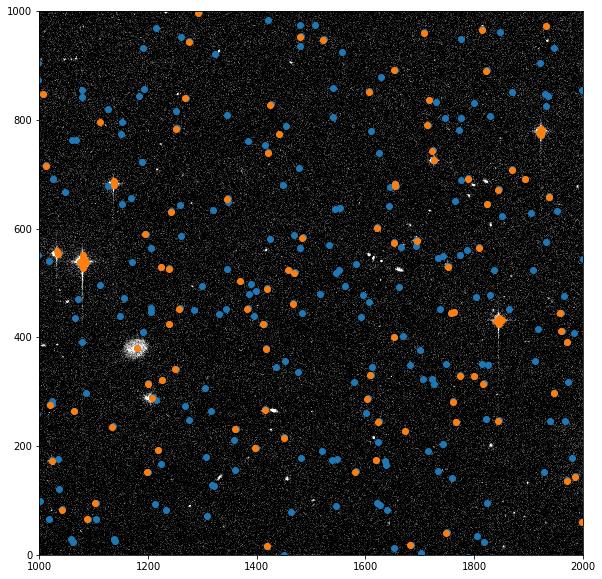

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(exampleData, vmin=1300 ,vmax=1500, cmap='gray') 

plt.scatter(pixelcoord[:,0],pixelcoord[:,1])

plt.scatter(x, y)

plt.ylim(0,1000)
plt.xlim(1000,2000)

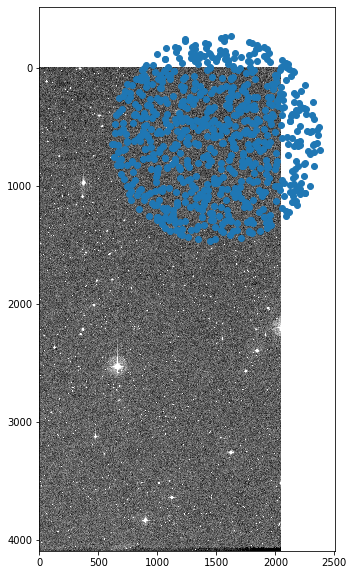

In [15]:
# smoothimage = convolve(exampleData,Box2DKernel(5))
# im = np.copy(smoothimage[1000:1500,1000:1500])
plt.figure(figsize=(10,10))
# plt.imshow(im,vmin=1200, vmax=1500, cmap='gray')             
# plt.colorbar()


plt.imshow(exampleData ,vmin=1200, vmax=1500, cmap='gray') 

plt.scatter(pixelcoord[:,0],pixelcoord[:,1])

In [16]:
mean = np.mean(exampleData)
median = np.median(exampleData)
sigma = np.std(exampleData)

bkg_sigma = mad_std(exampleData)

daofind = DAOStarFinder(fwhm=4., threshold=10.*bkg_sigma)

sources = daofind(exampleData)

#sources

positions = np.transpose((sources['xcentroid'],sources['ycentroid']))

apertures = CircularAperture(positions, r=4.) #the 4. is just good practice to avoid integers

phot_table = aperture_photometry(exampleData, apertures)

phot_table

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,91.48503919576818,1.608677064266311,51016.94158278308
2,885.531351563873,0.9444338700757595,59117.163317550214
3,2045.5180669100432,1.8509339654135233,41747.2018786837
4,680.1978301095953,5.835876659375713,95909.57234115234
5,346.5398918633736,10.81208356314831,96954.26922688479
6,867.7549129333798,16.081019278804824,68993.10986963319
7,1418.6584644272664,15.532022883041696,270768.4151088818
8,1682.035509716774,17.64510206637686,72173.7183812445


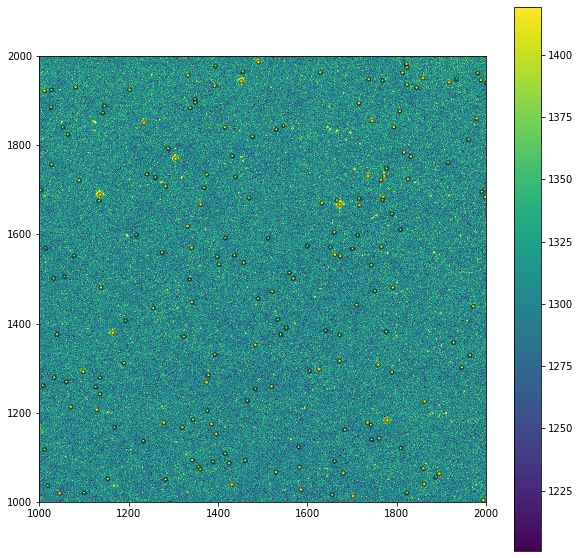

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(exampleData, vmin=median-.1*sigma, vmax=median+.1*sigma, cmap='viridis', origin='lower')
plt.colorbar()
plt.xlim(1000,2000)
plt.ylim(1000,2000)
apertures.plot(color='black', lw=1.5, alpha=0.5)

In [18]:
#s = 400, marker = 'o',facecolors='none', edgecolors = 'r'